# Глубинное обучение для текстовых данных, ФКН ВШЭ
## Домашнее задание 5: Retrieval‑Augmented Generation (RAG)
### Оценивание и штрафы

Максимально допустимая оценка за работу — __12 баллов__.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Весь код должен быть написан самостоятельно. Чужим кодом для пользоваться запрещается даже с указанием ссылки на источник. В разумных рамках, конечно. Взять пару очевидных строчек кода для реализации какого-то небольшого функционала можно.

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

__Мягкий дедлайн 04.12.25 23:59__ \
__Жесткий дедлайн 07.12.25 23:59__

### О задании

В этом домашнем задании вам предлагается реализовать ассистента для кулинарных советов с помощью RAG, который помимо всего прочего может ходить в итернет за дополнительной информацией. Всю логику системы нужно будет написать самостоятельно без специализорованных библиотек. Мы разделили ее на несколько логических компонент, каждой из которых будет отведено отдельное задание:
1. Векторная база данных с быстрым семантическим поиском
2. Разбиение текстов на куски.
3. Ранжирование документов по релевантности
4. Формирование контекста для модели и генерация ответа

### О данных

В качестве базы данных мы будем использовать пользовательские рецепты с сайта "Поваренок.Ру". Они получены с помощью веб-парсинга сайта, поэтому местами тексты недостаточно чистые. Всего в датасете содержится 84130 рецептов.

In [6]:
import matplotlib.pyplot as plt
import numpy as np

### Загрузка датасета и модели

Таблица с рецептами хранится в файле `povarenok.csv`. Каждая запись содержит название рецепта, список ингредиентов и сам рецепт. Несмотря на то, что всего датасете хранится 84130 записей, в рамках этого задания мы будем работать с первыми 10-ю тысячами для того, чтобы все работало быстрее. При желании вы можете взять больше.

In [7]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files=['povarenok.csv'], split='train')
dataset = dataset.select(range(10000))
dataset

Dataset({
    features: ['name', 'ingredients', 'text'],
    num_rows: 10000
})

In [8]:
dataset[0]

{'name': 'Густой молочно-клубничный коктейль',
 'ingredients': "['Молоко', 'Клубника', 'Сахар']",
 'text': 'Не размораживая, ягоду положите в блендер, добавьте молоко и сахар (если ягода свежая, то и перепелиное яйцо) Взбивайте на высокой скорости до полного измельчения ягод. Вылете в стаканы и можно по чуть-чуть пить, так как этот напиток оочень холодный. Кто не любит таковой, подождите и выпейте, когда он немного согреется. Приятного аппетита!'}

Посмотрим на распределение длин текстов. Нам важно знать с чем мы имеем дело, ведь RAG подразумевает, что мы будем подавать тексты на вход модели.

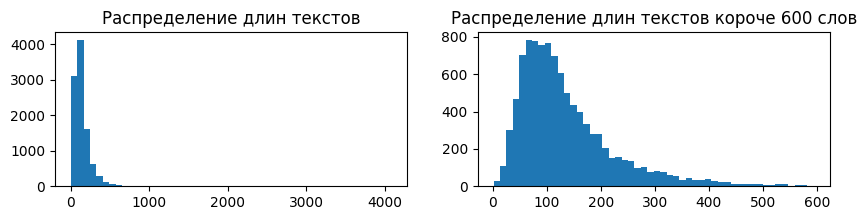

In [9]:
lens = np.array([len(dataset[i]['text'].split()) for i in range(len(dataset))])

plt.figure(figsize=(10, 2))
plt.subplot(1, 2, 1)
plt.hist(lens, bins=50)
plt.title('Распределение длин текстов')

plt.subplot(1, 2, 2)
plt.hist(lens[lens < 600], bins=50)
plt.title('Распределение длин текстов короче 600 слов')

plt.show()

Видим, что тексты часто довольно длинные. Поэтому смухлевать не получится и перед векторизацией нужно будет разбивать каждый текст на небольшие куски, чтобы не перегружать контекст модели и чтобы потерять важную информацию при векторизацци текстов на этапе складывания их в векторную базу данных.

Приступим к реализации RAG.

## Retrieval‑Augmented Generation

В качестве основы для ассистента возьмите модель [`Qwen/Qwen2-1.5B-Instruct`](https://huggingface.co/Qwen/Qwen2-1.5B-Instruct) из huggingface. Важно, что это `Instruct` модель, то есть она предлазначена для общения в формате диалога.

__Задание 0 (0 баллов).__ Проверьте, как модель отвечает на кулинарные вопросы без RAG. Это необходимо сделать, чтобы понять, нужен ли вообще RAG для данной задачи.

In [10]:
from transformers import pipeline

pipe = pipeline("text-generation", model="Qwen/Qwen2-1.5B-Instruct", device_map="auto")


questions = [
    "Как сварить яйцо вкрутую?",
    "Напиши рецепт классической карбонары.",
    "Что приготовить из гречки и тушенки?"
]

print("--- Проверка модели без RAG ---\n")

for question in questions:
    messages = [
        {"role": "system", "content": "Ты кулинарный помощник."},
        {"role": "user", "content": question}
    ]
    
    result = pipe(messages, max_new_tokens=500)
    answer = result[0]['generated_text'][-1]['content']
    
    print(f"Вопрос: {question}")
    print(f"Ответ Qwen: {answer}")
    print("-" * 30)

Device set to use cuda:1


--- Проверка модели без RAG ---

Вопрос: Как сварить яйцо вкрутую?
Ответ Qwen: Сварить яйца вкрутую можно несколькими способами, но наиболее распространенным является метод "мокрого" или "сухого" яичного взбития.

1. Начните с приготовления яиц. Их нужно поставить на огонь и добавить немного воды (например, 20 мл). Важно, чтобы вода была достаточно горячей, чтобы яйца не разбились, но не слишком горячей, чтобы они не пропали из-за перегрева.
   
2. Когда вода закипит, сразу же переверните яйца. Это поможет избежать образования пузырей внутри яиц, что может вызвать неприятные вкусовые ощущения.

3. Дайте яйцам подогреться примерно до полуголубой точки. Они должны быть мягкими и сладковатыми на вкус. 

4. После того как яйца готовы, можно их вынуть из кастрюли и аккуратно переложить на дуршлаг, чтобы стекла от остывшей воды.

5. Если у вас есть желание, вы можете добавить луковый паштет или зеленый чеснок, чтобы сделать яйца более сочными и ароматными.

6. Вы можете также добавить специи

### Locality Sensitive Hashing (LSH)

В RAG для каждого запроса необходимо искать релевантные документы по векторной базе данных. Так как документов очень много, подсчет релевантности для каждого из них будет занимать очень много времени. Поэтому нам важно, чтобы поиск был быстрым. Для достижения этого мы даже готовы немного пожертвовать точностью.

В этой секции вам предстоит реализовать [Locality Sensitive Hashing](https://ru.wikipedia.org/wiki/Locality-sensitive_hashing).

Идея LSH довольна проста. Разделим все векторы из базы данных на группы, состоящие из похожих векторов. В начале поиска определим группу, которая соответствует вектору запроса и будем считать релевантность только для объектов из этой группы. Для разбиения на группы мы введем несколько хеш-функций. Каждая их них будет строиться по следующему алгоритму:
1. Сгенерируем $k$ случайных векторов (векторы нормали гиперплоскости)
2. Для отдельной точки (вектора) в базе данных и вектора нормали запишем 1, если точка лежит над соответствующей гиперплоскостью. В обратном случае запишем 0.
3. Повторим процедуру для всех точек и векторов нормали. Так мы для каждой точки получим список из $k$ 0 и 1, который и будет хешем.
4. Запишем в хеш-таблицу найденные точки для каждого хеша.
5. Повторим шаги 1-4 $L$ раз и получим $L$ разных хеш-таблиц.

Теперь для каждого нового вектора $q$ мы можем очень быстро найти набор векторов похожих на него. Для этого посчитаем хеши запроса в каждой хеш-таблице и возьмем все точки, у которых хеш совпал c $q$ хотя бы в одной из них. Затем переранжируем найденные точки по релевантности (расстоянию до вектора запроса) и оставим заданное число самых близких.

Сложность формирования хеш-таблиц можно оценить как $O(nLkd)$, где $n$ – число векторов в базе данных, а $d$ – размерность вектора. В то же время сложность поиска LSH – $O(Lkd + (nLp) \cdot d)$, где $p$ – вероятность того, что хеш двух случайных точек совпадет ($p$ стремится к 0). Сложность полного перебора – $O(nd)$, поэтому при поиске LSH работает быстрее почти в $\frac{n}{Lk}$ раз!

__Задание 1 (3 балла).__ Реализуйте векторную базу данных LSH поиском. База данных должна уметь добавлять новые векторы, а так же по входному вектору быстро находить ближайшие к нему. Во время создании базы данных сгенерируйте необходимое число хеш-функций. Подумайте о том, как выбрать количество хеш-таблиц и число случайных векторов, а так же о том, из какого распределения брать эти случайные векторы. При добавлении нового вектора в базу данных, считайте для него хеш и записывайте, каким группам от принадлежит.

Постарайтесь оптимизировать код и не забудьте протестировать, что ваш LSH работает так, как надо. Проще всего это сделать, построив базу данных с точками на двумерной плоскости. Также сравните скорость LSH поиска с полным перебором. Если вы все сделали правильно, то для 1000 точек вы должны получить ускорение поиска примерно в 4 раза.

In [12]:
import numpy as np
import time
from collections import defaultdict

class LSHIndex:
    def __init__(self, input_dim, L=5, k=4):

        self.L = L
        self.k = k
        self.input_dim = input_dim
        

        self.vectors = {}
        

        self.tables = [defaultdict(list) for _ in range(L)]
        
        self.planes = np.random.randn(L, k, input_dim)

    def _compute_hashes(self, vector):

        projections = np.dot(self.planes, vector)
        bits = (projections > 0).astype(int)
        
        hashes = []
        for i in range(self.L):
            hash_key = tuple(bits[i]) 
            hashes.append(hash_key)
            
        return hashes

    def add_vector(self, vector_id, vector):


        self.vectors[vector_id] = vector
        

        hashes = self._compute_hashes(vector)

        for i, h_key in enumerate(hashes):
            self.tables[i][h_key].append(vector_id)

    def find_nearest(self, query_vector, top_n=5):

        hashes = self._compute_hashes(query_vector)
        

        candidate_ids = set()
        for i, h_key in enumerate(hashes):

            if h_key in self.tables[i]:
                candidate_ids.update(self.tables[i][h_key])
        
        if not candidate_ids:
            return []



        candidates = []
        for vid in candidate_ids:
            vec = self.vectors[vid]
            
            similarity = np.dot(vec, query_vector) / (np.linalg.norm(vec) * np.linalg.norm(query_vector) + 1e-10)
            candidates.append((vid, similarity))
            
        candidates.sort(key=lambda x: x[1], reverse=True)
        
        return candidates[:top_n]

In [14]:

NUM_VECTORS = 1000
DIM = 2
L_PARAM = 4   
K_PARAM = 20  
TOP_N = 10
data_vectors = np.random.randn(NUM_VECTORS, DIM)
data_vectors /= np.linalg.norm(data_vectors, axis=1, keepdims=True)

lsh = LSHIndex(input_dim=DIM, L=L_PARAM, k=K_PARAM)

start_build = time.time()
for i in range(NUM_VECTORS):
    lsh.add_vector(i, data_vectors[i])
print(f"База построена за {time.time() - start_build:.4f} сек")

query_vec = np.random.randn(DIM)
query_vec /= np.linalg.norm(query_vec)


# A. Полный перебор
start_bf = time.time()
distances = []
for i in range(NUM_VECTORS):
    vec = data_vectors[i]
    sim = np.dot(vec, query_vec) # Векторы уже нормализованы
    distances.append((i, sim))
distances.sort(key=lambda x: x[1], reverse=True)
bf_result = distances[:TOP_N]
time_bf = time.time() - start_bf

# B. Поиск LSH
start_lsh = time.time()
lsh_result = lsh.find_nearest(query_vec, top_n=TOP_N)
time_lsh = time.time() - start_lsh

print(f"\nРазмер базы: {NUM_VECTORS} векторов, Размерность: {DIM}")
print(f"LSH Параметры: L={L_PARAM}, k={K_PARAM}")
print("-" * 30)
print(f"Время Brute Force: {time_bf:.6f} сек")
print(f"Время LSH Search:  {time_lsh:.6f} сек")

if time_lsh > 0:
    speedup = time_bf / time_lsh
    print(f"Ускорение: x{speedup:.2f}")
else:
    print("Ускорение: бесконечно (слишком быстро)")

print("-" * 30)
bf_ids = set([x[0] for x in bf_result])
lsh_ids = set([x[0] for x in lsh_result])
intersection = bf_ids.intersection(lsh_ids)
print(f"Brute Force Top-{TOP_N}: {[x[0] for x in bf_result]}")
print(f"LSH Top-{TOP_N}:         {[x[0] for x in lsh_result]}")
print(f"Совпадение (Recall): {len(intersection)}/{TOP_N}")

База построена за 0.0163 сек

Размер базы: 1000 векторов, Размерность: 2
LSH Параметры: L=4, k=20
------------------------------
Время Brute Force: 0.001823 сек
Время LSH Search:  0.000871 сек
Ускорение: x2.09
------------------------------
Brute Force Top-10: [162, 890, 775, 816, 11, 597, 477, 214, 654, 539]
LSH Top-10:         [162, 890, 775, 816, 11, 597, 477, 214, 654, 539]
Совпадение (Recall): 10/10


### Разбиение текста на куски

Так как некоторые тексты довольно длинные, если мы будем кодировать их целиком одним вектором, то часть информации потеряется. Вектор все таки имеет ограниченный размер. Чтобы не терять информацию, мы поделим текст на куски и будем кодировать каждый кусок отдельно.

__Задание 2 (2 балла).__ Реализуйте [рекурсивное разбиение](https://dev.to/eteimz/understanding-langchains-recursivecharactertextsplitter-2846) текста с уровнями `["\n\n", "\n", " ", ""]`. Добавьте пересечение между кусками для уровней `[" ", ""]`. То есть если целый абзац помещается в один кусок, то пересекать его ни с чем не надо (в нем содержится законченная мысль), а если абзац не влезает и его приходится делить по словам (или символам), то нужно добавить пересечение со словами из соседних кусков того же абзаца.

Значения для максимального размера каждого куска и длины пересечения выберите самостоятельно. Надежнее всего брать размер пересечения равным половине длины куска.

In [15]:
class RecursiveTextSplitter:
    def __init__(self, chunk_size=512, chunk_overlap=256):

        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap

        self.separators = ["\n\n", "\n", " ", ""]

    def split_text(self, text):
        return self._split(text, self.separators)

    def _split(self, text, separators):

        if len(text) <= self.chunk_size:
            return [text]


        selected_sep = None
        next_separators = []
        
        for i, sep in enumerate(separators):
            if sep in text:
                selected_sep = sep
                next_separators = separators[i+1:]
                break
        

        if selected_sep is None:
            if "" in separators:
                selected_sep = ""
                next_separators = []
            else:
                return [text[i : i + self.chunk_size] for i in range(0, len(text), self.chunk_size)]


        if selected_sep == "":
            splits = list(text)
        else:
            splits = text.split(selected_sep)


        final_chunks = []
        current_chunk = []
        current_len = 0
        

        do_overlap = (selected_sep in [" ", ""])

        for split in splits:

            if len(split) > self.chunk_size:

                if current_chunk:
                    final_chunks.append(selected_sep.join(current_chunk))
                    current_chunk = []
                    current_len = 0
                

                sub_chunks = self._split(split, next_separators)
                final_chunks.extend(sub_chunks)
                continue


            sep_len = len(selected_sep) if current_chunk else 0
            
            if current_len + sep_len + len(split) > self.chunk_size:

                text_chunk = selected_sep.join(current_chunk)
                final_chunks.append(text_chunk)
                

                if do_overlap and self.chunk_overlap > 0:

                    overlap_buffer = []
                    overlap_len = 0
                    

                    for item in reversed(current_chunk):
                        item_len = len(item) + (len(selected_sep) if overlap_buffer else 0)
                        if overlap_len + item_len <= self.chunk_overlap:
                            overlap_buffer.insert(0, item) 
                            overlap_len += item_len
                        else:
                            break
                    
                    current_chunk = overlap_buffer
                    current_len = overlap_len
                    

                    current_chunk.append(split)

                    current_len += len(selected_sep) + len(split)
                else:

                    current_chunk = [split]
                    current_len = len(split)
            else:

                current_chunk.append(split)
                current_len += sep_len + len(split)


        if current_chunk:
            final_chunks.append(selected_sep.join(current_chunk))

        return final_chunks

In [16]:
dataset[5]['text']

'Для пирога тыкву нужно запечь в духовке. Разрезала тыкву, вынула семечки. И половину ещё разрезала пополам. Вот 2 четвертушки я и запеку 10 минут при Т-170 С. Пока тыква запекается, делаем тесто. Для замеса теста и заливки пирога я буду использовать комбайн (блендер, измельчитель). В чашу выложила всё сразу: сахар; масло; муку; яйцо и воду. Всё разбила в крошку. Руками обмяла, тесто чудесное и к рукам не пристаёт. Сформировала лепёшку и выложила в форму D-18,5 см. Она у меня разовая и подмазки не требует. Можно взять любую форму и обмазать её маслом, если она этого требует. Сформировала руками бортики (придала вид тарелки). Поставила в холодильник на 30 минут. В чашу комбайна (блендера) выгребаем ложкой мякоть тыквы, освобождая от кожуры. Выкладываем сгущённое молоко, корицу, мускатный орех, крахмал и яйцо. Всё разбиваем в однородную массу. Вынимаем форму с тестом из холодильника и выкладываем тыквенную массу. Ставим в духовку разогретую до Т-180 С на 30 минут. Ориентируйтесь на свою 

In [17]:

recipe_text = dataset[5]['text']

splitter = RecursiveTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_text(recipe_text)

print(f"Количество чанков: {len(chunks)}\n")
for i, chunk in enumerate(chunks):
    print(f"Chunk {i+1} [len: {len(chunk)}]:")
    print(f"'{chunk}'")
    print("-" * 20)

Количество чанков: 2

Chunk 1 [len: 998]:
'Для пирога тыкву нужно запечь в духовке. Разрезала тыкву, вынула семечки. И половину ещё разрезала пополам. Вот 2 четвертушки я и запеку 10 минут при Т-170 С. Пока тыква запекается, делаем тесто. Для замеса теста и заливки пирога я буду использовать комбайн (блендер, измельчитель). В чашу выложила всё сразу: сахар; масло; муку; яйцо и воду. Всё разбила в крошку. Руками обмяла, тесто чудесное и к рукам не пристаёт. Сформировала лепёшку и выложила в форму D-18,5 см. Она у меня разовая и подмазки не требует. Можно взять любую форму и обмазать её маслом, если она этого требует. Сформировала руками бортики (придала вид тарелки). Поставила в холодильник на 30 минут. В чашу комбайна (блендера) выгребаем ложкой мякоть тыквы, освобождая от кожуры. Выкладываем сгущённое молоко, корицу, мускатный орех, крахмал и яйцо. Всё разбиваем в однородную массу. Вынимаем форму с тестом из холодильника и выкладываем тыквенную массу. Ставим в духовку разогретую до Т-

## RAG

Наконец мы можем начать собирать систему RAG. Для начала соберем векторую базу данных из кусков рецептов. Для получения эмбеддингов текстов возьмите модель [`intfloat/multilingual-e5-large`](https://huggingface.co/intfloat/multilingual-e5-large), она создана специально для этой задачи и хорошо работает с русским языком.

__Задание 3 (1 балл).__ Соберите векторую базу данных с помощью написанных вами функций. Процесс не должен занимать много времени с GPU, но мы рекомендуем сохранить результат на диск, чтобы не векторизовать весь датасет заново при перезапуске ядра. Проверьте, что по запросу возвращаются релевантные тексты.

In [18]:
import pickle
import os
import numpy as np
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import torch

MODEL_NAME = 'intfloat/multilingual-e5-large'
EMBEDDING_DIM = 1024
DB_FILENAME = "recipes_lsh.pkl"


L_PARAM = 15
K_PARAM = 7

def build_vector_db(hf_dataset):

    model = SentenceTransformer(MODEL_NAME, device="cuda" if torch.cuda.is_available() else "cpu")
    
    splitter = RecursiveTextSplitter(chunk_size=1000, chunk_overlap=200)
    
    all_chunks_text = [] 
    chunk_metadata = {} 
    
    global_chunk_id = 0

    for row_idx, item in enumerate(tqdm(hf_dataset, desc="Splitting")):
        text = item['text']
        name = item['name'] 
        

        if not text:
            continue
            
        chunks = splitter.split_text(text)
        
        for chunk in chunks:
            all_chunks_text.append(f"passage: {chunk}")
            
            chunk_metadata[global_chunk_id] = {
                "text": chunk,
                "name": name,
                "source_id": row_idx
            }
            global_chunk_id += 1
            
    print(f"Всего получено чанков: {len(all_chunks_text)}")

    print("Генерация эмбеддингов...")
    embeddings = model.encode(all_chunks_text, batch_size=32, show_progress_bar=True, convert_to_numpy=True)
    
    embeddings /= np.linalg.norm(embeddings, axis=1, keepdims=True)

    print("Заполнение LSH индекса...")
    lsh = LSHIndex(input_dim=EMBEDDING_DIM, L=L_PARAM, k=K_PARAM)
    
    for i in tqdm(range(len(embeddings)), desc="Indexing"):
        lsh.add_vector(i, embeddings[i])
        
    return lsh, chunk_metadata, model


if os.path.exists(DB_FILENAME):
    print(f"Найден сохраненный индекс {DB_FILENAME}. Загружаем...")
    with open(DB_FILENAME, "rb") as f:
        saved_data = pickle.load(f)
        lsh_index = saved_data["lsh"]
        metadata = saved_data["metadata"]
    embedder = SentenceTransformer(MODEL_NAME, device="cuda" if torch.cuda.is_available() else "cpu")
else:
    print("Индекс не найден. Строим с нуля...")
    lsh_index, metadata, embedder = build_vector_db(dataset)
    
    with open(DB_FILENAME, "wb") as f:
        pickle.dump({"lsh": lsh_index, "metadata": metadata}, f)
    print(f"Индекс сохранен в {DB_FILENAME}")



def search(query, top_n=3):
    query_text = f"query: {query}"
    query_emb = embedder.encode(query_text)
    

    query_emb /= np.linalg.norm(query_emb)
    

    results = lsh_index.find_nearest(query_emb, top_n=top_n)
    
    print(f"\n Запрос: '{query}'")
    if not results:
        print("Ничего не найдено.")
        return

    for idx, score in results:
        info = metadata[idx]
        print(f"[{score:.4f}] Блюдо: '{info['name']}'")
        print(f"   ...{info['text'][:150].replace(chr(10), ' ')}...")
        print("-" * 40)

search("Напиши рецепт классической карбонары.")

Найден сохраненный индекс recipes_lsh.pkl. Загружаем...

 Запрос: 'Напиши рецепт классической карбонары.'
[0.8324] Блюдо: 'Коктейль "Сладкий витамин"'
   ...Все ингредиенты смешать, хорошо взбить миксером. Охладить. Приятного!...
----------------------------------------
[0.8306] Блюдо: 'Котлета куриная по ГОСТу "Сделана в СССР"'
   ...писали, хорошие рецепты разрабатывали. Есть чему поучиться, даже в наш продвинутый век инет-технологий. Так что будем учиться новому, вспоминая старое...
----------------------------------------
[0.8263] Блюдо: 'Ягодно-молочный кисель'
   ...В двух чашечках развести крахмал: 1 ст. л. в 50 мл холодного молока, и 1 ст. л. в 50 мл. холодной воды В оставшихся 150 мл. воды развести 2 ст. л. кон...
----------------------------------------


In [19]:
for x in dataset['text']:
    if 'карбонара' in x.lower():
        print(x)

Карбонары нет в датасете :((

In [20]:
search("Напиши рецепт пиццы")


 Запрос: 'Напиши рецепт пиццы'
[0.8664] Блюдо: 'Тонкая домашняя пицца'
   ...Продукты, необходимые для приготовления пиццы. Разведите дрожжи в молоке. Добавьте 1 яйцо, 3 ст.ложки подс.масла, щепотку соли, 3 стол.ложки сахара. П...
----------------------------------------
[0.8641] Блюдо: 'Пицца   "Яркая"'
   ...Поставим тесто и приготовим ингредиенты для пиццы. Грибы, морковь, лук, сельдерей, ветчина, яйцо. Сыр, белок, укроп. Тесто готово. Присыпать мукой и р...
----------------------------------------
[0.8638] Блюдо: 'Супер-пицца'
   ...Смазать поверхность теста кетчупом , хорошенько посыпать начинкой наверх начинки посыпать сыр. Завернуть рулетом Острым ножом порезать на порционные к...
----------------------------------------


### Формирование контекста для модели и генерация ответа

Из всех компонент RAG эта самая творческая. Надо придумать промпт, который будет лучше всего помогать модели генерировать ответ.

__Задание 4 (1 балл).__ Напишите функцию для генерации ответа по текстовому запросу в парадигме RAG. Найдите релевантные документы и соберите из них промпт, объяснив дополнительно модели, что от нее требуется. Количество текстов в промпте ограничивайте отбирая топ самых релевантных. Заметьте, что в нашем датасете помимо рецепта есть список ингредиентов и название блюда. Подумайте о том, как можно их использовать. Предайте промпт в модель для получения ответа. Подберите гиперпараметры генерации, чтобы контролировать разнообразие. Помните, что модель должна строго соответствовать инструкциям, не придумывать факты и не генерировать то, что от нее не требуется. Продемонстрируйте ваши результаты на 3-5 примерах.

In [21]:
def reorder_documents_lost_in_middle(documents):
    """Сортировка: [1, 2, 3, 4, 5] -> [1, 3, 5, 4, 2]"""
    if not documents: return []
    left = [doc for i, doc in enumerate(documents) if i % 2 == 0]
    right = [doc for i, doc in enumerate(documents) if i % 2 != 0]
    return left + right[::-1]

In [22]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
GENERATOR_MODEL_NAME = "Qwen/Qwen2-1.5B-Instruct"
class RAGAssistant:
    def __init__(self, lsh_index, metadata, embedder, dataset):
        self.lsh = lsh_index
        self.metadata = metadata
        self.embedder = embedder
        self.dataset = dataset
        
        print(f"Загрузка LLM модели: {GENERATOR_MODEL_NAME}...")
        self.tokenizer = AutoTokenizer.from_pretrained(GENERATOR_MODEL_NAME)
        self.model = AutoModelForCausalLM.from_pretrained(
            GENERATOR_MODEL_NAME,
            torch_dtype="auto",
            device_map="auto"
        )

    def generate_answer(self, query, top_k=5):

        query_emb = self.embedder.encode(f"query: {query}")
        query_emb /= np.linalg.norm(query_emb)
        
        results = self.lsh.find_nearest(query_emb, top_n=top_k)
        
        if not results:
            return "К сожалению, в моей базе рецептов ничего не найдено."

        docs_list = []
        for idx, score in results:
            meta = self.metadata[idx]
            source_id = meta['source_id']
            full_record = self.dataset[source_id]
            
            # Ингредиенты в строку
            ingr = full_record.get('ingredients', [])
            if isinstance(ingr, list):
                ingr = ", ".join(ingr)
                
            doc_text = (
                f"--- БЛЮДО: {full_record.get('name', 'Рецепт')} ---\n"
                f"ИНГРЕДИЕНТЫ: {ingr}\n"
                f"ОТРЫВОК ИНСТРУКЦИИ: {meta['text']}"
            )
            docs_list.append(doc_text)
            

        reordered_docs = reorder_documents_lost_in_middle(docs_list)
        full_context = "\n\n".join(reordered_docs)

        # 4. Промптинг
        system_prompt = (
            "Ты профессиональный шеф-повар. Твоя задача — отвечать на вопросы пользователя строго по контексту.\n"
            "Правила:\n"
            "1. Используй только предоставленные рецепты.\n"
            "2. Не выдумывай ингредиенты или шаги, которых нет в тексте.\n"
            "3. Если информации недостаточно или контекст плохой, честно скажи об этом.\n"
            "4. Структурируй ответ."
        )
        
        user_prompt = f"КОНТЕКСТ:\n{full_context}\n\nВОПРОС: {query}"
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ]
        
        text_input = self.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = self.tokenizer([text_input], return_tensors="pt").to(self.model.device)

        generated_ids = self.model.generate(
            inputs.input_ids,
            max_new_tokens=600,
            temperature=0.3, 
            top_p=0.9,
            do_sample=True
        )
        
        generated_ids = [out[len(inp):] for inp, out in zip(inputs.input_ids, generated_ids)]
        response = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        
        return response, full_context

In [23]:
rag = RAGAssistant(lsh_index, metadata, embedder, dataset)

Загрузка LLM модели: Qwen/Qwen2-1.5B-Instruct...


`torch_dtype` is deprecated! Use `dtype` instead!


In [24]:
questions = [
    "Как сварить яйцо вкрутую?",
    "Напиши рецепт классической карбонары.",
    "Что приготовить из гречки и тушенки?"
]

In [25]:
print("\n=== RAG CHAT ===\n")
for q in questions:
    print(f"User: {q}")
    ans, ctx = rag.generate_answer(q, top_k=5)
    print(f"Assistant: {ans}")
    print("-" * 50)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



=== RAG CHAT ===

User: Как сварить яйцо вкрутую?
Assistant: Яйцо сварить вкрутую можно следующими способами:

1. Варите яйцо в воде. Это самый простой и быстрый метод. Вылейте воду в кастрюлю, положите в нее яйцо и закройте крышкой. Варите яйцо примерно 8-10 минут, затем откройте крышку и уберите яйцо из воды. 

2. Используйте специальные инструменты для варки яиц. Есть модели, которые позволяют варить яйца прямо в них, что делает процесс более удобным и быстрым.

3. Если вы хотите, чтобы яйцо было немного жёстче, используйте специальный инструмент для варки яиц "вкрутую".

Выберите любой из этих способов и начните готовить свой любимый вид яиц!
--------------------------------------------------
User: Напиши рецепт классической карбонары.
Assistant: Карбонары - это классический булочник, который готовится из муки, сахара и воды. Вот простой рецепт для вас:

**Ингредиенты:**
- 250 г муки
- 100 г сахара
- 100 мл воды

**Шаги приготовления:**

1. Перемешайте муку, сахар и воду в большой

### Поиск в интернете

Как вы должны были заметить, языковая модель с RAG работает куда лучше, чем без него. Несмотря на это, она все равно регулярно галлюционирует. Качество RAG подхода помимо самих компонент RAG во многом зависит от датасета и модели. Например, датасет с рецептами может не содержать каких-то фактов о самих блюдах, а некоторых блюд вообще может не быть. В таком случае модель не сможет правильно ответить на вопрос. Давайте улучшим качество формирования контекста, добавив возможность сестеме искать информацию в интернете.

__Задание 5 (2 балла).__ Модифицируйте процесс извлечения релевантных текстов следующим образом. Если в топе оказались тексты с недостаточно высокой (по порогу) похожестью на запрос, то замените их текстами, найденными по запросу в интернете, у которых похожесть достаточно высокая. Таким образом, модель всегда будет получать фиксированное число максимально релевантных текстов на вход.

При поиске в интернете мы будем пользоваться тем, что все поисковики сортируют выдачу по соответствию запросу. Значит мы можем взять наш запрос, вставить его в поисковик и пройти по выданным ссылкам, анализируя текст на каждой странице до тех пор, пока не наберем достаточное число релевантных текстов. Для хождения в интернет вам потребуется библиотека [`requests`](https://requests.readthedocs.io/en/latest/), а для извлечения текста со страницы проще всего использовать [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/).

Получилось ли у вас улучшить качество ответов?

In [26]:
import requests
from bs4 import BeautifulSoup
import numpy as np



def search_duckduckgo(query, max_results=3):

    url = "https://html.duckduckgo.com/html/"
    payload = {'q': query, 'kl': 'ru-ru'} 
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    
    try:
        response = requests.post(url, data=payload, headers=headers, timeout=10)
        soup = BeautifulSoup(response.text, 'html.parser')
        
        links = []
        for a in soup.find_all('a', class_='result__a'):
            href = a.get('href')
            if href and href.startswith('http'):
                links.append(href)
                if len(links) >= max_results:
                    break
        return links
    except Exception as e:
        print(f"Ошибка поиска: {e}")
        return []

def fetch_and_parse_url(url):

    headers = {
        "User-Agent": "Mozilla/5.0"
    }
    try:
        response = requests.get(url, headers=headers, timeout=5)
        if response.status_code != 200:
            return ""
            
        soup = BeautifulSoup(response.content, 'html.parser')
        
        for script in soup(["script", "style", "nav", "footer", "header"]):
            script.extract()
            
        text = soup.get_text(separator=' ')

        lines = (line.strip() for line in text.splitlines())
        chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
        text = '\n'.join(chunk for chunk in chunks if chunk)
        
        return text
    except Exception as e:

        return ""



class WebRAGAssistant(RAGAssistant): 
    def __init__(self, lsh_index, metadata, embedder, dataset, text_splitter):

        super().__init__(lsh_index, metadata, embedder, dataset)
        self.splitter = text_splitter 

    def generate_answer_hybrid(self, query, top_k=5, threshold=0.82):


        query_emb = self.embedder.encode(f"query: {query}")
        query_emb /= np.linalg.norm(query_emb)
        

        local_results = self.lsh.find_nearest(query_emb, top_n=top_k)
        
        good_docs = []
        if local_results:
            for idx, score in local_results:
                if score >= threshold:
 
                    meta = self.metadata[idx]
                    full_record = self.dataset[meta['source_id']]
                    
                    ingr = full_record.get('ingredients', [])
                    if isinstance(ingr, list):
                        ingr = ", ".join(ingr)
                    
                    text_block = (
                            f"--- БЛЮДО: {full_record.get('name', 'Рецепт')} ---\n"
                            f"ИНГРЕДИЕНТЫ: {ingr}\n"
                            f"ОТРЫВОК ИНСТРУКЦИИ: {meta['text']}"
                    )
                    good_docs.append({'text': text_block, 'score': score})
        
        print(f"Найдено локальных документов с score > {threshold}: {len(good_docs)}")


        missing_count = top_k - len(good_docs)
        
        if missing_count > 0:
            print(f"Недостаточно данных. Ищу в интернете (нужно еще {missing_count})...")
            urls = search_duckduckgo(query, max_results=3)
            
            web_chunks_data = []
            

            for url in urls:
                print(f"Скачивание: {url}...")
                raw_text = fetch_and_parse_url(url)
                if not raw_text: continue
                
                chunks = self.splitter.split_text(raw_text[:5000])
                
                for chunk in chunks:
                    web_chunks_data.append({
                        'text': chunk,
                        'url': url
                    })
            

            if web_chunks_data:

                passages = [f"passage: {item['text']}" for item in web_chunks_data]
                
                web_embs = self.embedder.encode(passages, convert_to_numpy=True)
                web_embs /= np.linalg.norm(web_embs, axis=1, keepdims=True)
                
                scores = np.dot(web_embs, query_emb)

                web_candidates = []
                for i, score in enumerate(scores):

                    web_candidates.append({
                        'text': (
                            f"--- ИСТОЧНИК: ИНТЕРНЕТ ({web_chunks_data[i]['url']}) ---\n"
                            f"Текст: {web_chunks_data[i]['text']}"
                        ),
                        'score': score
                    })
                

                web_candidates.sort(key=lambda x: x['score'], reverse=True)
                good_docs.extend(web_candidates[:missing_count])



        good_docs.sort(key=lambda x: x['score'], reverse=True)

        good_docs = good_docs[:top_k]
        

        final_texts = [doc['text'] for doc in good_docs]
        
        if not final_texts:
            return "Не удалось найти информацию ни в базе, ни в интернете."


        reordered_texts = reorder_documents_lost_in_middle(final_texts)
        full_context = "\n\n".join(reordered_texts)


        system_prompt = (
            "Ты профессиональный шеф-повар. Твоя задача — отвечать на вопросы пользователя строго по контексту.\n"
            "Правила:\n"
            "1. Используй только предоставленные рецепты.\n"
            "2. Не выдумывай ингредиенты или шаги, которых нет в тексте.\n"
            "3. Если информации недостаточно или контекст плохой, честно скажи об этом.\n"
            "4. Структурируй ответ."
        )
        user_prompt = f"КОНТЕКСТ:\n{full_context}\n\nВОПРОС: {query}"
        
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ]
        
        text_input = self.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = self.tokenizer([text_input], return_tensors="pt").to(self.model.device)

        generated_ids = self.model.generate(
            inputs.input_ids,
            max_new_tokens=600,
            temperature=0.3,
            do_sample=True
        )
        
        generated_ids = [out[len(inp):] for inp, out in zip(inputs.input_ids, generated_ids)]
        response = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        
        return response




splitter = RecursiveTextSplitter(chunk_size=1000, chunk_overlap=200)


web_rag = WebRAGAssistant(lsh_index, metadata, embedder, dataset, splitter)



Загрузка LLM модели: Qwen/Qwen2-1.5B-Instruct...


In [27]:



q1 = "Как приготовить шарлотку?"
print(f"Вопрос 1: {q1}")
ans1 = web_rag.generate_answer_hybrid(q1, top_k=3, threshold=0.85)
print(f"Ответ:\n{ans1}\n")
print("-" * 50)

q2 = "Напиши рецепт классической карбонары."
print(f"Вопрос 2: {q2}")
ans2 = web_rag.generate_answer_hybrid(q2, top_k=3, threshold=0.85) # Высокий порог заставит искать в вебе
print(f"Ответ:\n{ans2}\n")

Вопрос 1: Как приготовить шарлотку?
Найдено локальных документов с score > 0.85: 3
Ответ:
Шарлотка - это классический рецепт пирога, который можно приготовить следующим образом:

1. Начнем с подготовки ингредиентов: яйцо куриное, яблоко, сахар, мука пшеничная, сода, уксус.

2. Яблоки нужно очистить, удалить кожуру и нарезать на дольки. 

3. Взбиваем яйца с сахаром. 

4. Добавляем муку по чуть-чуть, порциями, готовое тесто должно напоминать густую сметану. 

5. Добавляем соду гашенную уксусом. 

6. Влейте кусочки яблок в тесто...

7. Миксируем все ингредиенты. 

8. Выкладываем в форму, смазанную маслом и посыпанную мукой и ставим в разогретую духовку на средний огонь до готовности. 

9. Готовая шарлотка должна иметь золотистую корочку и приятный аромат. 

10. Приятного аппетита!

--------------------------------------------------
Вопрос 2: Напиши рецепт классической карбонары.
Найдено локальных документов с score > 0.85: 0
Недостаточно данных. Ищу в интернете (нужно еще 3)...
Скачивание

Да, стало сильно лучше!

__Бонус [история] (1 балл)__. Важный недостаток текущего подхода заключается в том, что ассистенту нельзя задавать уточняющие вопросы по его же ответам. Приходится переписывать весь запрос целиком, добавляя больше деталей. Это, в целом, решение, но будет лучше, если в системе будет сохраняться история общения, а затем использоваться при генерации нового ответа. В этом задании вам предлагается добавить этот функционал. 

Существует много способов встраивания истории в модель. Например, можно просто сохранить все вопросы и ответы и подавать их в контекст. Однако такой способ значительно увеличит размер промпта, из-за чего увеличатся затраты по времени и памяти на каждый ответ. Конечно, можно попробовать фильтровывать историю, оставляя только те запросы и ответы, которые касаются текущего запроса. Тем не менее, это все еще будет перегружать промпт. Поэтому есть подход куда лучше.   
Перед поиском релевантных текстов попросим модель переформулировать полученный запрос так, чтобы он стал более полным и включал в себя контекст предыдущего общения. Например, `"Какая у него каллорийность?" -> "Какая каллорийность у салата Цезарь?"`. С таким новым запросом мы сможем искать релевантные тексты с учетом истории, не увеличивая итоговый размер промпта.

Реализуйте описанную схему. Для переформулирования запроса используйте ту же модель, что и для генерации, и убедитесь, что она хорошо справляется со своей задачей. С какими сложностями вы столкнулись?

__Задание 6 (1 балл).__ Продемонстрируйте работу вашего финального ассистента в различных сценариях (разные темы вопросов, разная сложность). Приведите примеры как удачных, так и неудачных ответов. Почему ваша система не всегда работает как надо? Какие у нее есть ограничения и какие преимущества? Как вы думаете, что можно сделать, чтобы ее улучшить?

In [28]:

test_scenarios = [

    {
        "type": "Easy / Local DB",
        "query": "Как приготовить классическую шарлотку с яблоками?"
    },
    

    {
        "type": "Medium / Web Search",
        "query": "Рецепт Дубайского шоколада с фисташковой пастой"
    },
    

    {
        "type": "Hard / Reasoning",
        "query": "Чем отличаются ингредиенты для борща и щей? Перечисли разницу."
    },
    

    {
        "type": "Trick / Hallucination risk",
        "query": "Как сварить бетонный блок в кастрюле?"
    }
]



for scenario in test_scenarios:
    print(f"СЦЕНАРИЙ: {scenario['type']}")
    print(f"Вопрос: {scenario['query']}")
    
    start_time = time.time()

    answer = web_rag.generate_answer_hybrid(scenario['query'], top_k=3, threshold=0.85)
    elapsed = time.time() - start_time
    
    print(f"Время: {elapsed:.2f} сек")
    print(f"Ответ:\n{answer}")
    print("=" * 60 + "\n")

СЦЕНАРИЙ: Easy / Local DB
Вопрос: Как приготовить классическую шарлотку с яблоками?
Найдено локальных документов с score > 0.85: 3
Время: 11.04 сек
Ответ:
Шарлотка - это классический рецепт, который можно приготовить следующим образом:

1. **Подготовка ингредиентов**: 
   - Яйцо куриное
   - Яблоко
   - Сахар
   - Мука пшеничная
   - Сода
   - Уксус
   - Соль

2. **Выпечка теста**: 
   - Яйца взбиваем с сахаром, добавляя муку постепенно, пока получится густая сметана. 
   - Добавляем соду гашенной уксусом и перемешиваем.

3. **Выкладывание теста**: 
   - Яблоки очищаем и нарезаем на маленькие кубики.
   - В форму, смазанную маслом и покрытую мукой, выкладываем яблоки.
   - Разравниваем тесто и отправляем в разогретую духовку на средний огонь до готовности.

4. **Выпечка**: 
   - Готовая шарлотка должна иметь золотистую корочку и приятный аромат.

После того как шарлотка будет готова, она будет иметь золотистую корочку и приятный аромат. Приятного аппетита!

СЦЕНАРИЙ: Medium / Web Searc

Разработан гибридный RAG-ассистент на базе модели `Qwen2-1.5B-Instruct`. Реализован собственный алгоритм приближенного поиска (LSH) для ускорения работы с векторной базой и механизм веб-поиска (DuckDuckGo) для обработки запросов, отсутствующих в локальном датасете.

**Результаты**
1.  **Локальный поиск:** Показывает высокую точность и скорость на стандартных запросах (пример: "Шарлотка"). Система корректно извлекает контекст и ингредиенты.
2.  **Защита от галлюцинаций:** RAG успешно фильтрует вопросы не по теме (пример: "Бетонный блок"), используя системный промпт и анализ контекста.
3.  **Веб-поиск:** Технически работает и закрывает пробелы в знаниях (актуальные тренды), но качество страдает из-за шума при парсинге HTML.

**Ограничения и выводы**

Главным "узким местом" является малый размер генеративной модели (1.5 млрд параметров). Она успешно пересказывает один источник, но путается при попытке логического обобщения противоречивой информации (кейс "Борщ vs Щи") и иногда смешивает факты из "грязного" веб-контекста. Думаю, для улучшения качества требуется переход на модели 7B+ и внедрение этапа переранжирования.

__Бонус [Self-Query] (1 балл)__. Предлагаем вам почитать про метод [SelfQuery](https://medium.com/%40danushidk507/rag-x-self-query-retriever-952dd55c68ed) и реализовать его. Если описывать вкратце: мы при помощи модели проводим предобработку запроса и выделяем из него некоторые метаданные, по которым можем фильтроваться по датасету. Например, в запросе "хочу что-то сладкое клубничное, но без манго" выделим продукты "клубника" и "манго", а дальше проведём фильтр по базе данных на основе продуктов, и в полученном подмножестве найдём "что-то сладкое".

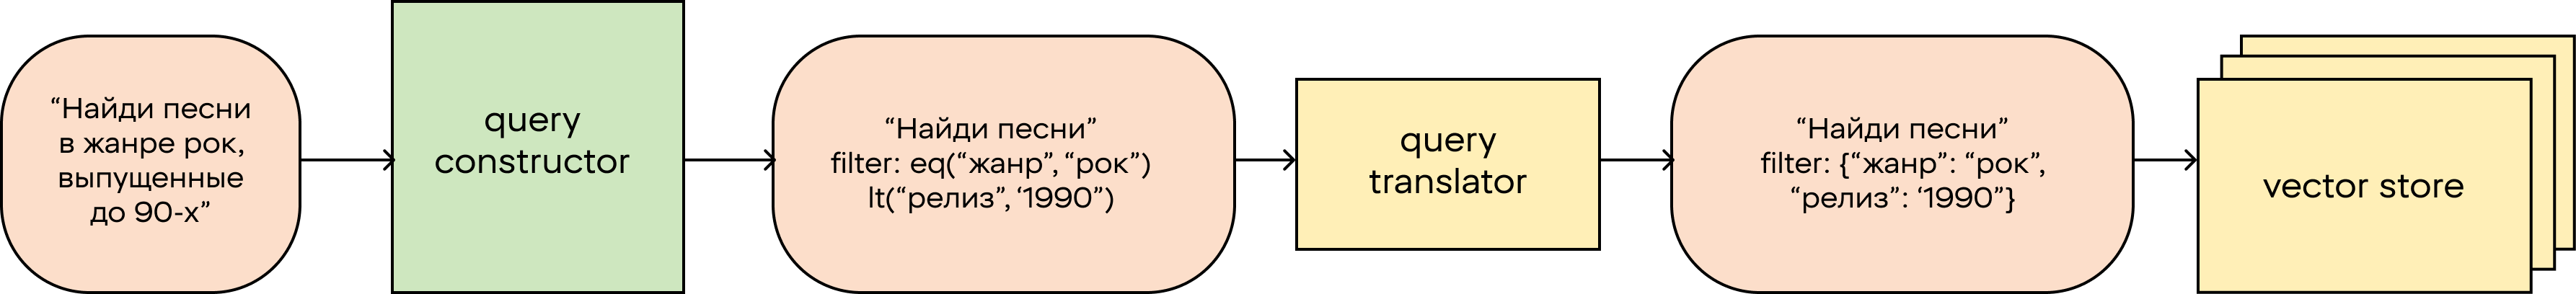

Для выделения метаданных можете воспользоваться либо генерацией json'а в определенном формате, либо SGR.

[Schema-Guided Reasoning (SGR)](https://abdullin.com/schema-guided-reasoning/) — это метод, который побуждает большие языковые модели (LLM) к созданию структурированных, понятных и предсказуемых ответов, заставляя их рассуждать по заранее определённым шагам. Создавая специальную схему (или структурированный шаблон), вы явно задаёте:

* какие этапы модель обязана пройти (не допускает пропуска или потери логики),
* в каком порядке должна происходить цепочка рассуждений (обеспечивает связность),
* на что именно следует обратить внимание (повышает глубину и точность).

Вместо свободной генерации текста — часто непоследовательной или двусмысленной — схема выступает жёстким ориентиром. Эта структура затем принудительно применяется к модели с помощью ограниченного декодирования (structured output).